<a href="https://colab.research.google.com/github/ducvu/ml_projects/blob/master/ens_valeo_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Prepare Problem


## Load libraries

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import numpy as np
import math

from keras.models import Sequential
from keras.layers import BatchNormalization,Dropout,Dense,Flatten,Conv1D
from tensorflow.keras.optimizers import Adam

## Load dataset

In [6]:
df_train_input = pd.read_csv('/content/traininginputs.csv')
df_train_output = pd.read_csv('/content/trainingoutput.csv')
df_test_input = pd.read_csv('/content/testinputs.csv')

## Prepare utilitiy functions

In [3]:
def print_percent_missing(df, nb):
    data = pd.DataFrame(df)
    df_cols = list(pd.DataFrame(data))
    dict_x = {}
    for i in range(0, len(df_cols)):
        dict_x.update({df_cols[i]: round(data[df_cols[i]].isnull().mean()*100,2)})    

    df_miss = sorted(dict_x.items(), key=lambda x: x[1], reverse=True)
    print('Percent of missing data', df_miss[0:nb])    

def print_duplicate(df, colname):
    idsUnique = len(set(df[colname]))
    idsTotal = df.shape[0]
    idsDupli = idsTotal - idsUnique
    print("Input there are " + str(idsDupli) + " duplicate IDs for " + str(idsTotal) + " total entries")



# Summarize Data

## Descriptive statistics

In [14]:
print("----------------------------------------------------------------------")
print_duplicate(df_train_input, 'PROC_TRACEINFO')
print_duplicate(df_train_output, 'PROC_TRACEINFO')
print_duplicate(df_test_input, 'PROC_TRACEINFO')

print("----------------------------------------------------------------------")
print("Missing value df_train_input : ", df_train_input.isnull().sum().max())
print("Missing value df_train_output : ", df_train_output.isnull().sum().max())
print("Missing value test df_test : ", df_test_input.isnull().sum().max())

print("----------------------------------------------------------------------")
print_percent_missing(df_train_input, 5)
print_percent_missing(df_test_input, 5)

print("----------------------------------------------------------------------")
print("Missing value df_train_input OP100_Capuchon_insertion_mesure: ", df_train_input['OP100_Capuchon_insertion_mesure'].isnull().sum())
print("Missing value df_train_output OP100_Capuchon_insertion_mesure: ", df_test_input['OP100_Capuchon_insertion_mesure'].isnull().sum())

----------------------------------------------------------------------
Input there are 0 duplicate IDs for 34515 total entries
Input there are 0 duplicate IDs for 34515 total entries
Input there are 0 duplicate IDs for 8001 total entries
----------------------------------------------------------------------
Missing value df_train_input :  18627
Missing value df_train_output :  0
Missing value test df_test :  4360
----------------------------------------------------------------------
Percent of missing data [('OP100_Capuchon_insertion_mesure', 53.97), ('PROC_TRACEINFO', 0.0), ('OP070_V_1_angle_value', 0.0), ('OP090_SnapRingPeakForce_value', 0.0), ('OP070_V_2_angle_value', 0.0)]
Percent of missing data [('OP100_Capuchon_insertion_mesure', 54.49), ('PROC_TRACEINFO', 0.0), ('OP070_V_1_angle_value', 0.0), ('OP090_SnapRingPeakForce_value', 0.0), ('OP070_V_2_angle_value', 0.0)]
----------------------------------------------------------------------
Missing value df_train_input OP100_Capuchon_i

In [18]:
# The classes are heavily skewed 0.88% frauds vs 99.12 no frauds
print("---------------------------------------------------------------------")
print('No Frauds: ', df_train_output['Binar OP130_Resultat_Global_v'].value_counts()[0], " or ", round(df_train_output['Binar OP130_Resultat_Global_v'].value_counts()[0]/len(df_train_output) * 100,2), '% of the dataset')
print('Frauds', df_train_output['Binar OP130_Resultat_Global_v'].value_counts()[1], " or ", round(df_train_output['Binar OP130_Resultat_Global_v'].value_counts()[1]/len(df_train_output) * 100,2), '% of the dataset')

---------------------------------------------------------------------
No Frauds:  34210  or  99.12 % of the dataset
Frauds 305  or  0.88 % of the dataset


In [19]:
df_train_input.describe()

,OP070_V_1_angle_value,OP090_SnapRingPeakForce_value,OP070_V_2_angle_value,OP120_Rodage_I_mesure_value,OP090_SnapRingFinalStroke_value,OP110_Vissage_M8_torque_value,OP100_Capuchon_insertion_mesure,OP120_Rodage_U_mesure_value,OP070_V_1_torque_value,OP090_StartLinePeakForce_value,OP110_Vissage_M8_angle_value,OP090_SnapRingMidPointForce_val,OP070_V_2_torque_value
count,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,15888.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000,34515.000000
mean,159.906922,156.915055,159.618236,113.350222,11.970190,12.256785,0.388173,11.971027,6.548403,23.630152,17.878398,97.700978,6.550867
std,15.662650,11.271492,15.091490,3.528522,0.169873,0.065319,0.024425,0.003050,0.097602,2.546341,6.785079,6.837714,0.094814
min,101.800000,0.000000,82.000000,99.990000,0.000000,12.030000,0.240000,11.970000,5.670000,0.000000,6.300000,0.000000,5.740000
25%,148.700000,149.210000,149.400000,111.040000,11.850000,12.210000,0.380000,11.970000,6.410000,22.280000,13.500000,94.310000,6.420000
50%,158.000000,156.180000,158.700000,113.160000,12.040000,12.260000,0.390000,11.970000,6.610000,23.880000,16.400000,98.500000,6.610000
75%,169.300000,164.380000,168.900000,115.380000,12.080000,12.300000,0.410000,11.970000,6.620000,25.290000,20.200000,102.230000,6.610000
max,198.300000,196.920000,198.100000,177.950000,12.190000,12.500000,0.420000,11.990000,6.670000,43.410000,84.600000,127.300000,6.670000


In [21]:
print(df_train_output.groupby('Binar OP130_Resultat_Global_v').size())

Binar OP130_Resultat_Global_v
0    34210
1      305
dtype: int64


## Data visualizations

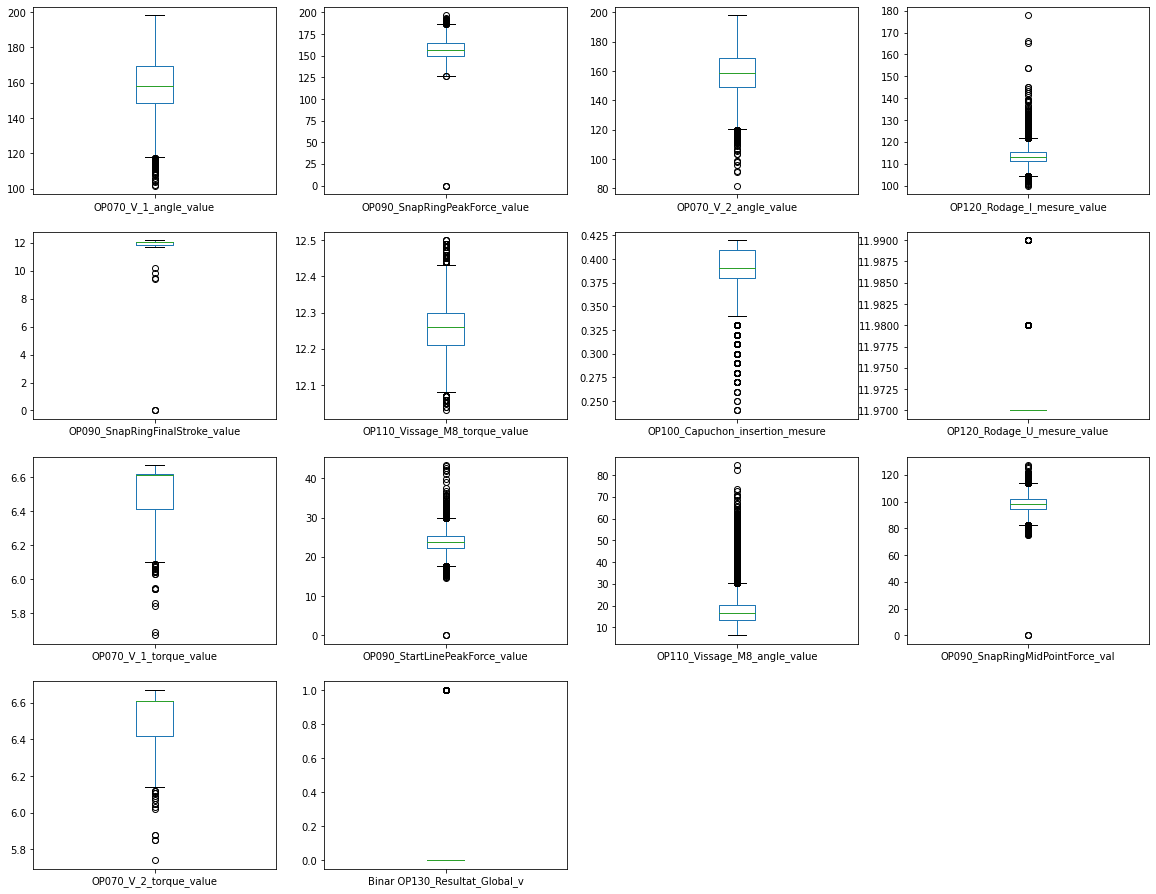

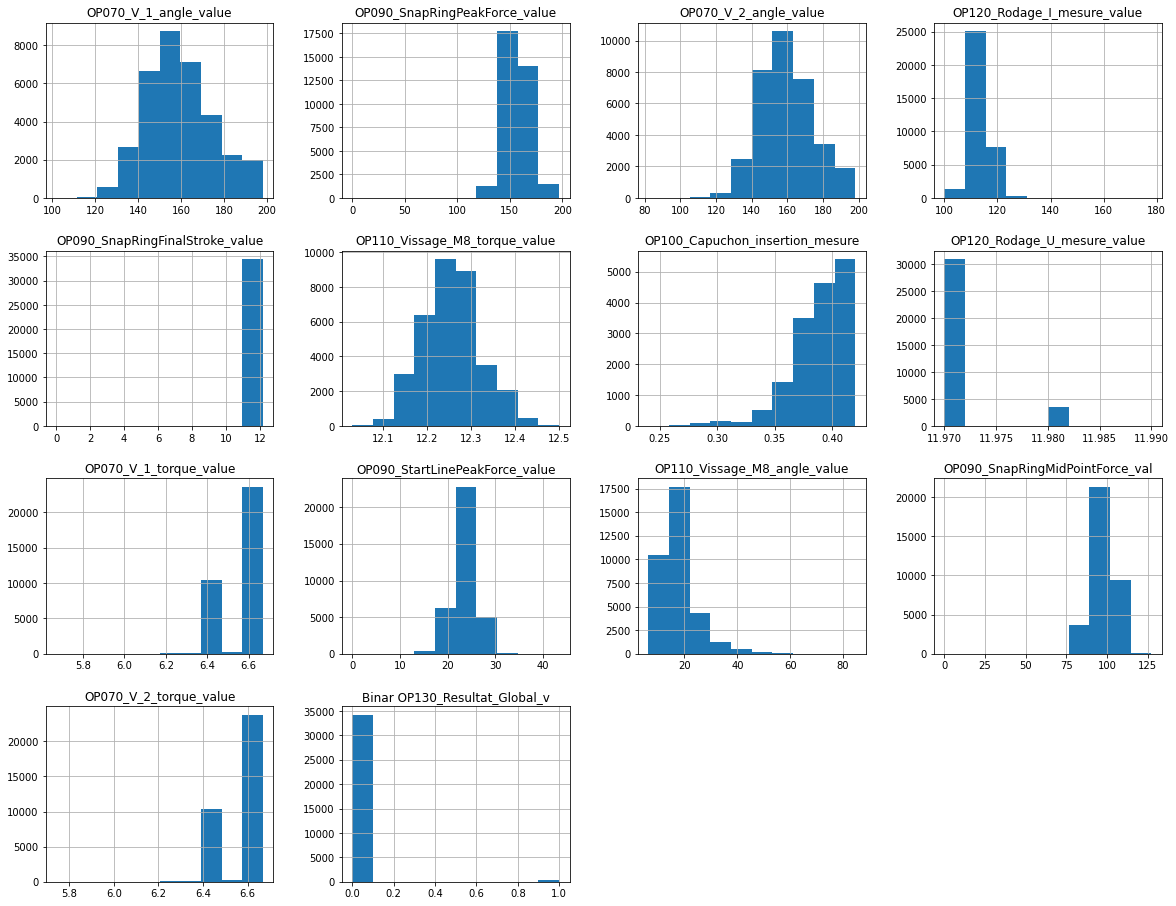

In [16]:
df_train = pd.merge(df_train_input, df_train_output, on='PROC_TRACEINFO', how='left')

# Box plot
df_train.plot(kind='box', layout=(5,4), figsize=(20, 20), subplots=True, sharex=False, sharey=False)
plt.show()

# Histogram
df_train.hist(layout=(5,4), figsize=(20, 20))
plt.show()

# Prepare Data

## Data Cleaning

In [25]:
# train data = train input + train output
df_train = pd.merge(df_train_input, df_train_output, on='PROC_TRACEINFO', how='left')
df_train['OP100_Capuchon_insertion_mesure'] = df_train['OP100_Capuchon_insertion_mesure'].fillna(0)
df_test_input['OP100_Capuchon_insertion_mesure'] = df_test_input['OP100_Capuchon_insertion_mesure'].fillna(0)

# drop ID column
df_train = df_train.drop('PROC_TRACEINFO', axis=1)

df_majority = df_train[df_train["Binar OP130_Resultat_Global_v"]==0]
df_minority = df_train[df_train["Binar OP130_Resultat_Global_v"]==1]

In [9]:
# Up-sample Minority Class
from sklearn.utils import resample
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=df_majority.shape[0],    # to match majority class
                                 random_state=123) # reproducible results 
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
print(df_upsampled.groupby('Binar OP130_Resultat_Global_v').size())

Binar OP130_Resultat_Global_v
0    34210
1    34210
dtype: int64


In [10]:
# Down-sample Majority Class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=123) # reproducible results 
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
print(df_downsampled.groupby('Binar OP130_Resultat_Global_v').size())

Binar OP130_Resultat_Global_v
0    305
1    305
dtype: int64


## Feature Selection

## Data Transforms

# Evaluate Algorithms

## Split-out validation dataset

In [27]:
X = df_upsampled.drop(['Binar OP130_Resultat_Global_v'],axis=1)
Y = df_upsampled['Binar OP130_Resultat_Global_v']

validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

X_test = df_test_input.drop('PROC_TRACEINFO', axis=1)
X_test = X_test.to_numpy()

In [53]:
Y.describe()

count    68420.000000
mean         0.500000
std          0.500004
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: Binar OP130_Resultat_Global_v, dtype: float64

## Scale data

In [28]:
# Scale data
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_train = scaler.fit_transform(X_train)

X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Test options and evaluation metric

## Spot Check Algorithms

In [52]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='roc_auc')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.678560 (0.003196)
LDA: 0.676723 (0.003318)
KNN: 0.993135 (0.000551)
CART: 0.992786 (0.000642)
NB: 0.648321 (0.005201)
XGB: 0.881193 (0.004976)


KeyboardInterrupt: ignored

In [53]:
# Spot-Check Algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('XGB', XGBClassifier()))
#models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
  kfold = KFold(n_splits=5, shuffle=True, random_state=seed)
  cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='f1')
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)

LR: 0.634063 (0.007014)
LDA: 0.622848 (0.006410)
KNN: 0.981087 (0.001332)
CART: 0.992850 (0.000456)
NB: 0.570221 (0.007109)
XGB: 0.813346 (0.005006)


In [50]:
sorted(metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

## Compare Algorithms

# Improve Accuracy

## Algorithm Tuning

In [ ]:
# Fine tune XGBoost
param_dist = {"max_depth": np.linspace(1, 32, 32, endpoint=True),
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}


## Ensembles

# Finalize Model


## Predictions on validation dataset


In [43]:
model = XGBClassifier()
model.fit(X_train, Y_train)
Y_pred = model.predict(X_validation)

from sklearn import metrics
print("Accuracy:",metrics.roc_auc_score(Y_validation, Y_pred))

print(sum(Y_pred), sum(Y_validation))
type(Y_pred)
len(Y_pred)

Accuracy: 0.8083921115746213
7181 6711


13684

In [45]:
# Make file for submission
Y_pred = model.predict(X_test)

df1 = df_test_input["PROC_TRACEINFO"]
df2 = pd.DataFrame(Y_pred)
res = pd.concat([df1, df2], axis=1)
res.columns = ["PROC_TRACEINFO", "Binar OP130_Resultat_Global_v"]
res.to_csv("/content/submission_XGB.csv", index=False)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finish


In [47]:
from google.colab import files
files.download('/content/submission_XGB.csv')  # 0.671 AUROC 
print("Finish")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Finish


## Create standalone model on entire training dataset

## Save model for later use